In [1]:
# https://machinelearningmastery.com/lstm-autoencoders/
# https://github.com/gentnerlab/buckeye/blob/master/buckeye_seq2seq.py

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
import numpy as np

In [4]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils import plot_model

In [6]:
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [7]:
class seq2seq_autoencoder(tf.keras.Model):
    """ an autoencoder based on LSTM 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(seq2seq_autoencoder, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        return self.enc(x)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        z = self.encode(x)
        _x = self.decode(z)
        ae_loss = tf.reduce_mean(tf.square(x - _x))
        return ae_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as tape:
            ae_loss = self.compute_loss(x)

        # compute gradients
        gradients = tape.gradient(ae_loss, self.trainable_variables)

        return gradients

    def apply_gradients(self, gradients):

        self.optimizer.apply_gradients(
            zip(gradients, self.trainable_variables)
        )

    def train(self, train_dataset):
        for train_x in tqdm(train_dataset, leave=False):
            gradients = self.compute_gradients(train_x)
            self.apply_gradients(gradients)

In [8]:
seq_len = 20
batch_size =1024
ndims = 2
nbatches = 10

In [9]:
def sin_gen(seq_len=20, ndims = ndims, batches=batch_size*nbatches, noise=0):
    """ This is just a generator to make some wavs
    """
    x = np.linspace(0, np.pi, seq_len)
    for i in range(batches):
        a = np.random.normal(1)
        b = np.random.rand()
        chans = np.array([((
            np.random.rand(1)
            * np.sin((x +  b * np.pi) * a)
            + np.random.normal(size=seq_len) * noise) + ch
        ).reshape((seq_len, 1))
        for ch in range(ndims)]).T.reshape(seq_len, ndims)
        
        yield chans

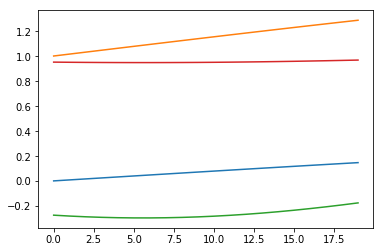

In [10]:
data_gen = sin_gen()
for i in range(2):
    sample = next(data_gen)
    for dim in sample.T:
        plt.plot(dim)

In [11]:
ds = (
    tf.data.Dataset.from_generator(
        sin_gen, (tf.float32), (tf.TensorShape([seq_len, ndims]))
    )
    .shuffle(batch_size*20)
    .batch(batch_size)
    .prefetch(10)
)

W0503 16:53:02.333548 139698483492608 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:410: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [18]:
ds

<DatasetV1Adapter shapes: (None, 20, 2), types: tf.float32>

In [36]:
from tensorflow.keras.layers import (
    RepeatVector,
    Dense,
    TimeDistributed,
    Conv1D,
)  # , LSTM
from tensorflow.python.keras.layers.recurrent import UnifiedLSTM as LSTM

units = 100
enc = [
    Conv1D(filters=32, kernel_size=5, padding="valid", activation="relu", strides=1),
    LSTM(units=units, activation="relu"),
    RepeatVector(seq_len),
]
dec = [
    LSTM(units=units, activation="relu", return_sequences=True),
    TimeDistributed(Dense(ndims)),
]

W0503 17:11:12.700350 139698483492608 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f0d50229c88>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0503 17:11:12.709540 139698483492608 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f0d50356b00>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [37]:
optimizer = tf.keras.optimizers.Adam(.001, beta_1=0.5)

model = seq2seq_autoencoder(
    enc = enc,
    dec = dec,
    optimizer = optimizer
)

In [38]:
import seaborn as sns

In [42]:
def visualize_results(ds, model, batch_loss, palette = sns.color_palette('Set1')):
    next_x = next(iter(ds))
    z = model.encode(next_x)
    x = model.decode(z)
    nex = 10
    
    fig, axs = plt.subplots(ncols=nex, figsize=(nex*2, 2))
    for i in range(nex):
        for dim in range(np.shape(x)[-1]):
            axs[i].plot(x.numpy()[i].squeeze().T[dim], label = 'gen', ls = ':', color = palette[dim])
            axs[i].plot(next_x.numpy()[i].squeeze().T[dim], label='true', color = palette[dim])
        #axs[i].axis('off')
    plt.show()
    print("Epoch: {} | Loss: {}".format(epoch, batch_loss))
    

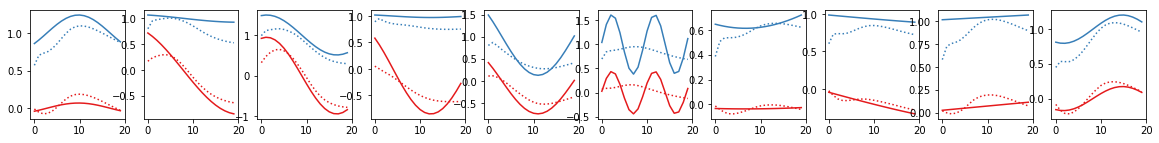

Epoch: 0 | Loss: 0.053961656987667084


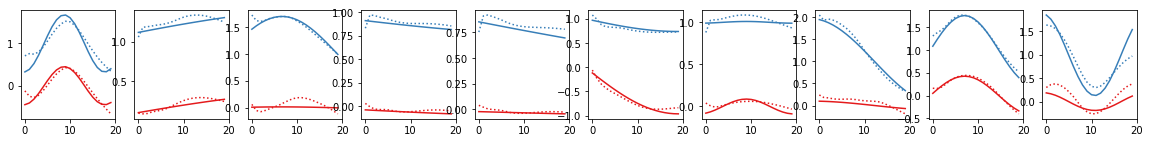

Epoch: 1 | Loss: 0.022289874032139778


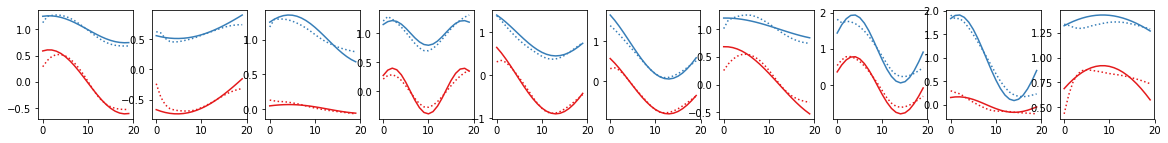

Epoch: 2 | Loss: 0.017261071130633354


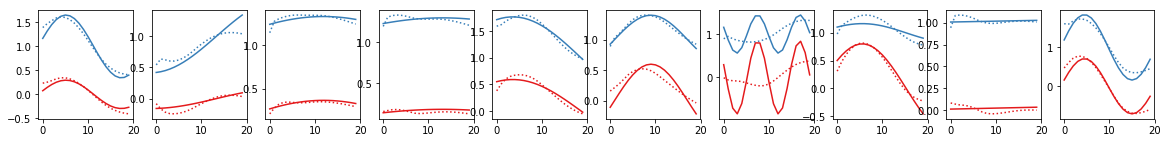

Epoch: 3 | Loss: 0.017014149576425552


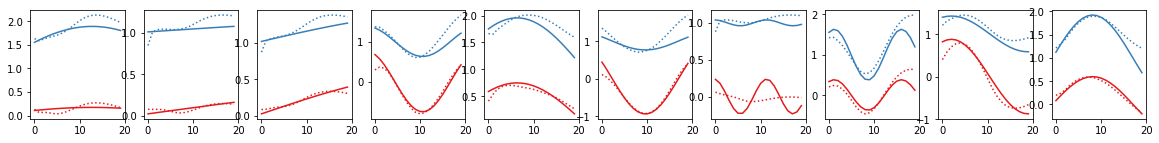

Epoch: 4 | Loss: 0.027311792597174644


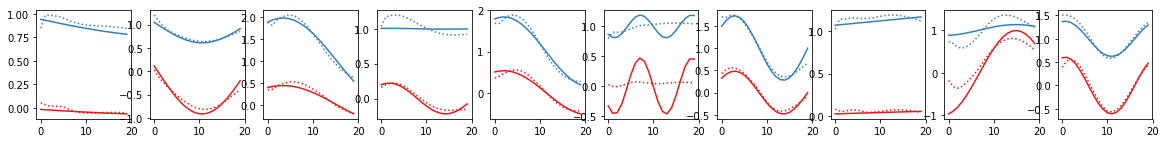

Epoch: 5 | Loss: 0.016364213079214096


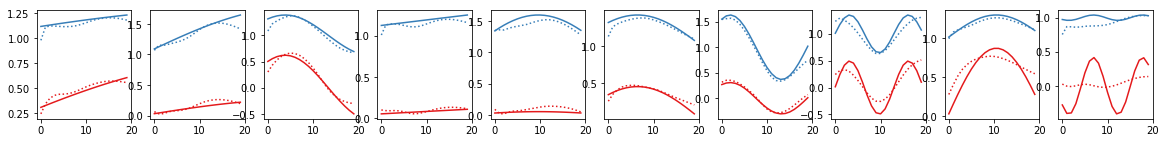

Epoch: 6 | Loss: 0.014955614693462849


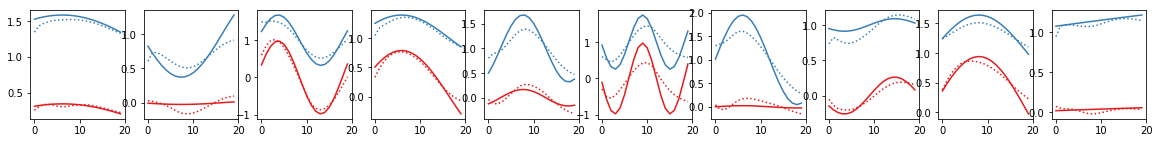

Epoch: 7 | Loss: 0.017361978068947792


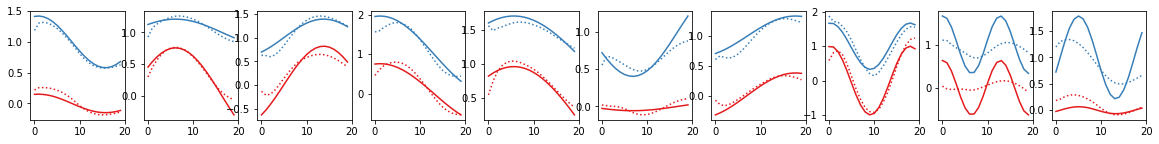

Epoch: 8 | Loss: 0.01689145341515541


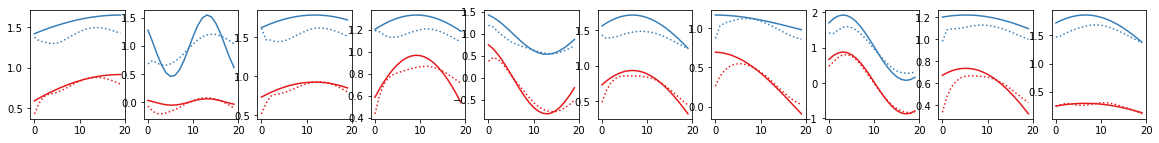

Epoch: 9 | Loss: 0.01984609290957451


In [45]:
losses = []
for epoch in range(10):
    model.train(train_dataset=ds)
    # compute loss
    batch_loss = np.sum(model.compute_loss(next(iter(ds))).numpy())
    losses.append(batch_loss)
    # viz results
    visualize_results(ds, model, batch_loss)
    

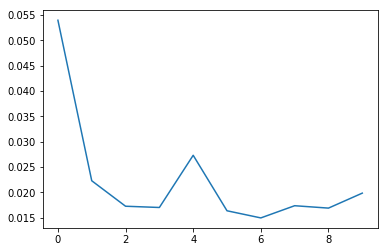

In [46]:
plt.plot(losses)